In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
plt.rcParams.update({'font.size': 14})

# physical constants
c       = 3e8                    # speed of light [m/s]
k_B     = 8.617333262145e-5      # Boltzmann constant [eV/K]
hbar    = 6.582119569e-16        # Reduced Planck constant [eV*s]
m_e     = 5.485e-4               # electron mass [eV*(s/m)^2]

# material constants
E_F     = 5.0                    # Chemical potential [eV]
T_F     = E_F/k_B                # Fermi temperature [K]

# system constants
T_e     = 300                    # electron system temperature [K]
E_L     = 2.25                   # pump photon energy [eV]
EF_L    = 5e2                    # pump field strength [V^2/m^2]
EF_sat  = 1e13                   # saturation field [V^2/m^2]

delta_E = (EF_L/EF_sat)**2       # non-equilibrium factor [a.u.]

: 

## eDOS (in 3D), Fermi-Dirac with 1st Order Chemical Potential

**Electronic density of states**

$$ \rho_e(\mathcal{E}) = \frac{{m_e}^{3/2}}{\pi^2\hbar^3}\sqrt{2\mathcal{E}} $$

**Fermi-Dirac distribution**

$$ f^{T}(\mathcal{E}) = \frac{1}{\exp\Big(\frac{\mathcal{E}-\mu}{k_{B}T}\Big)+1} $$

**Chemical potential (first-order in $T/T_F$)**

$$ \mu(T) = \mathcal{E}_{\scriptsize F}\left[1- \frac{\pi^{2}}{12}\left( \frac{T}{T_{\scriptsize F}} \right)^{2}\right] $$



In [2]:
def g(E):
    return ( ((m_e)**(3/2)) / ((np.pi**2)*(hbar**3)) )*np.sqrt(2*E)

def f_T(E):
    C = ((np.pi**2)/12)
    # chemical potential for fermi gas with T << T_F in 3D
    mu = E_F*( 1 - C*((T_e/T_F)**2))
    return 1 / (np.exp((E - mu) / (k_B * T_e)) + 1)

# Thermal Emission

**need to consider using the scipy.quad() integration which estimates the error.**

$$
I_e^{(T)}(E_{\mathrm{em}}) = \int_{E_{\min}}^{E_{\max}} f_T(E + E_{\mathrm{em}})\bigl[1 - f_T(E)\bigr]g(E + E_{\mathrm{em}})g(E) \mathrm{d}E
$$

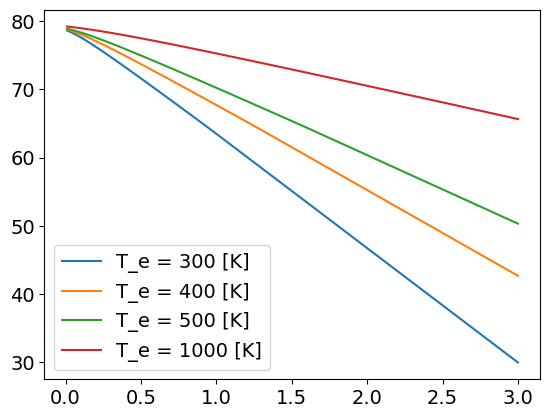

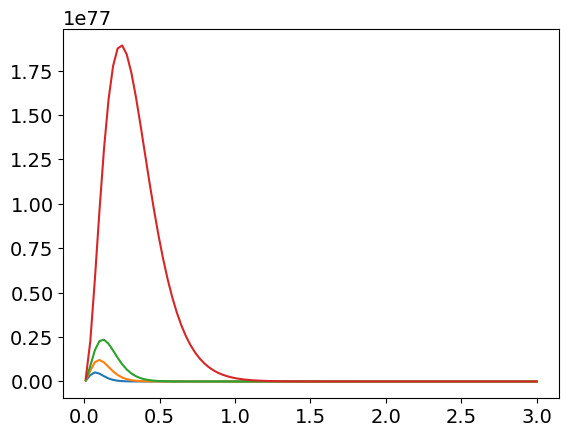

In [38]:
# emission integrand
def j_T(E, E_em):
        return f_T(E + E_em) * (1 - f_T(E)) * g(E + E_em) * g(E)

E_min = 0.0                               # lower limit [eV]
E_max = 10.0                              # upper limit [eV]
dE = 1e-4                                 # integration step [eV]
E = np.arange(E_min, E_max, dE)           # integration range [eV]
E_em_vals = np.linspace(0.01, 3.0, 100)   # emisison energy [eV]

#integration over energy
for T_e in [300, 400, 500, 1000]:
        I_e_T = np.array( [simpson(j_T(E, E_em), E) for E_em in E_em_vals] )
        plt.plot(E_em_vals, np.log10(I_e_T), label = f'T_e = {T_e} [K]')
        plt.legend()
plt.show()
#integration over energy (vectorized)

# j_vals = j_T(E[:, None], E_em_vals[None, :])  # shape: (len(E), len(E_em_vals))
# # print(j_vals)
# I_e_T = simpson(j_vals, x=E, axis=0)
# plt.plot(E_em_vals, np.log10(I_e_T))

for T_e in [300, 400, 500, 1000]:
        I_e_T = np.array( [(E_em**2)*simpson(j_T(E, E_em), E) for E_em in E_em_vals] )
        plt.plot(E_em_vals,I_e_T, label = f'T_e = {T_e} [K]')
plt.show()


# Non-thermal Emission

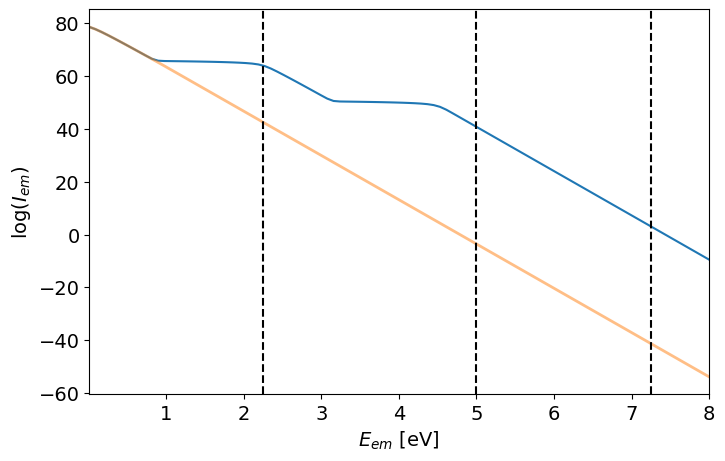

In [31]:
E_F = 5
E_L = 2.25
delta_E = 1e-15

# nonthermal distribution
def f_NT(E):
    A = f_T(E - E_L)*( 1 - f_T(E) )
    B = f_T(E)*( 1 - f_T(E + E_L) )
    return delta_E*(A-B)

# nonequilibrium distribution
def f(E):
    return f_T(E) + f_NT(E)

def j(E, E_em):
    return f(E + E_em) * (1 - f(E)) * g(E + E_em) * g(E)

#integration over energy
I_e = np.array( [simpson(j(E, E_em), E) for E_em in E_em_vals] )

fig, ax  = plt.subplots(figsize = (8,5))
ax.plot(E_em_vals, np.log10(I_e))
ax.plot(E_em_vals, np.log10(I_e_T), linewidth = 2, alpha = 0.5)
# ax.plot(E_em_vals, np.log10(f_T(E_em_vals)))
ax.set(xlabel=r'$E_{em}$ [eV]', ylabel=r'$\log(I_{em})$')
ax.set( xlim = (E_em_vals[0], E_em_vals[-1]) )

ax.axvline(x = E_L, color = 'k', linestyle = 'dashed')
ax.axvline(x = E_F, color = 'k', linestyle = 'dashed')
ax.axvline(x = E_F + E_L, color = 'k', linestyle = 'dashed')